Begin by importing SimpleITK and creating an ImageSeriesReader. We will use this SimpleITK function to get a series of DICOM images and select from them which to use during our clustering segmentation pipeline.

In [16]:
import SimpleITK as sitk

reader = sitk.ImageSeriesReader()
seriesIDs = reader.GetGDCMSeriesIDs("DICOM")
numSeries = len(seriesIDs)

dicomSeriesID = 0
dicomNames = reader.GetGDCMSeriesFileNames("DICOM", seriesIDs[dicomSeriesID])
reader.SetFileNames(dicomNames)
try:
    image = reader.Execute()
except RunTimeError:
    print ("--> Something went wrong reading DICOM names!")
    

Write out a more convenient format for research, namely, the compressed NIFTI.

In [17]:
sitk.WriteImage(image, "DICOM.nii.gz")

We can use this later if we just want to start with the DICOM data but in our compressed NIFTI format. NIFTI also has the advantage of being naturally de-identified, however, the DICOM data I have given you in this tutorial is already de-identified for obvious reasons.

Now we do some simple conversion. First, we will apply a total variation denoising procedure to the images, which is available in the skimage package, which removes some random noise. In this case we are also grabbing the numpy array representation of the imageSecondly, we scale the data and convert it to 8 bit in preparation for using our pymeanshift library, which works only with 8 bit image data.

In [18]:
from skimage.restoration import denoise_tv_chambolle
import cv2
import numpy as np

numpyImage = denoise_tv_chambolle(sitk.GetArrayFromImage(image), weight=0.001)

alpha = 255.0 / np.amax(numpyImage)
beta = np.amin(numpyImage)

numpyImage = cv2.convertScaleAbs(numpyImage, alpha=alpha, beta=beta)

For the purposes of this demonstration our goal is to perform the mean shift segmentation on a single axial slide of the MRI which contains a significant amount of tumor. In this demo I have pre-configured the axial slide value corresponding to this 2D slice of the image, however, one could imagine a straightforward 3D version of this code (but beware! this is computationally expensive!) or an interactive image picker writtein in, for example, matplotlib.

In [37]:
imageSlice = 45
myImage = numpyImage[imageSlice]
myImage.shape

(256, 256)

Let's take a look at our image.

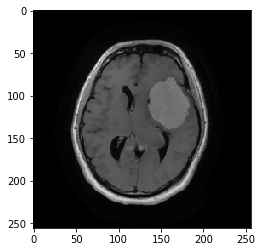

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(myImage, cmap='gray')

Two significant configurable options exist within the construction of the mean shift segmenter. The first is the spatial radius. This is the radius around each seed point which will be considered for the centroid calculation. The second is the range radius, which is defined as the range in the image density that will be considered to be part of the centroid calculation at each iteration and for each seed point. Lastly, there is a minimum density set so that no pixels below a certain threshold are considered in the calculation. This has the effect of removing the background. I have pre-populated some values for you here, however, feel free to play around with this.

In [41]:
spatialRadius = 2
rangeRadius = 6
minDensity = 10

import pymeanshift as pms
from PIL import Image

mySegmenter = pms.Segmenter()
mySegmenter.min_density = minDensity
mySegmenter.spatial_radius = spatialRadius
mySegmenter.range_radius = rangeRadius

segmentedImage, labelImage, numRegions = mySegmenter(myImage)

ModuleNotFoundError: No module named 'pymeanshift'